# ECE-GY 6143 - Machine Learning Project

## Analyzing impacts of Attacks and Counters on Image Classifiers

Tanmay Khot - tsk9863 <br>
Rigveda Vangipurapu - rv2205

# Installation

In [ ]:
#flickrapi
!pip install flickrapi

In [ ]:
# Adversarial Robustness Toolbox
import sys
!{sys.executable} -m pip install adversarial-robustness-toolbox==1.5.1 tensorflow==2.3.1 Keras==2.4.3 matplotlib==3.3.2 ipywidgets==7.6.3

  Using cached matplotlib-3.3.2-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.3.2
Uninstalling matplotlib-3.3.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.2
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yell

In [ ]:
# Install ImageNet stubs:
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-x27s6ybq
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-x27s6ybq


# Utility functions

In [ ]:
import matplotlib.pyplot as plt

def makegraph(acc_dict, title):

  names = list(acc_dict.keys())
  values = list(acc_dict.values())
  plt.xlabel("%")
  plt.ylabel("accuracy")
  plt.title(title)

  plotfig = plt.plot(names,values, linewidth=2.0)
 

# Code

In [ ]:
import flickrapi
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import requests
from io import BytesIO
from PIL import Image


# For SSIM
from skimage import metrics

# For PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
from scipy.stats import stats
import matplotlib.image as mpimg
from PIL import Image as im


# Load basic dependencies:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np

# For Adversarial attacks
# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

# Load Keras dependencies:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical
from art.attacks.evasion import FastGradientMethod

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name


%matplotlib inline

In [ ]:
# see the flickr demo on where to get keys. 
api_key = u'17e77d77492197f4c429bfd3cdd6fbfe41'  # use your Key
api_secret = u'8cdd8092ad79460bfe'  # Use your secret
flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [ ]:
import warnings
import os

dir_name = 'test'
dir_exists = os.path.isdir(dir_name)
if not dir_exists:
    os.mkdir(dir_name)
    print("Making directory %s" % dir_name)
else:
    print("Will store images in directory %s" % dir_name)


Will store images in directory test


In [ ]:
classes = ['golden_retriever','persian_cat','ambulance','school_bus','traffic_light']

In [ ]:
for i in classes:
   
  dir_folder = os.path.join(os.getcwd(),'test',i)
  dir_exists = os.path.isdir(dir_folder)
  if not dir_exists:
      os.mkdir(dir_folder)
      print("Making directory %s" % dir_folder)
  else:
      print("Will store images in directory %s" % dir_folder)

Will store images in directory /content/test/golden_retriever
Will store images in directory /content/test/persian_cat
Will store images in directory /content/test/ambulance
Will store images in directory /content/test/school_bus
Will store images in directory /content/test/traffic_light


In [ ]:
n_images = 500

for _ in classes:
  keyword = _
  dir_name = _
  photos = flickr.walk(text=keyword, tag_mode='all', tags=keyword,extras='url_c',\
                      sort='relevance',per_page=100)

  i = 0
  nrow = 224
  ncol = 224
  for photo in photos:
      url=photo.get('url_c')
      if not (url is None):
          
          # Create a file from the URL
          # This may only work in Python3
          response = requests.get(url)
          file = BytesIO(response.content)
          
          # Read image from file
          im = skimage.io.imread(file)
          
          # Resize images
          im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')
                  
          # Convert to uint8, suppress the warning about the precision loss
          with warnings.catch_warnings():
              warnings.simplefilter("ignore")
              im2 = skimage.img_as_ubyte(im1)
      
          # Save the image
    
          local_name = '{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',dir_name,keyword, i)
          skimage.io.imsave(local_name, im2)
          if i%100 == 0:
            print("Downloaded: ",local_name)
          i = i + 1        
      if (i >= n_images):        
          break        


In [ ]:
#!zip -r /content/project_data.zip /content/test
# Drive link: https://drive.google.com/file/d/1mdvke76_2fybm6J00g2qJ-2e5a20zPvY/view?usp=sharing

# Image classification


In [ ]:
#Loading pretrained deep network
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#clear keras session
import tensorflow.keras.backend as K 
K.clear_session()


In [ ]:
#Set the dimensions of the input image
nrow = 150
ncol = 150

input_shape = (nrow,ncol,3)


In [ ]:
def predictlabel(model):
  label = []
  yhat=[]
  res= dict()
  for i in classes: 
    for d in range(n_images):
      image = load_img('{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d))
      image = img_to_array(image)
      image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
      image = preprocess_input(image)
      yhat = model.predict(image)
      l = decode_predictions(yhat)
      # print(l[0][0][1])
      res['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] = l[0][0][1]
  return res

In [ ]:
from keras.applications.resnet import ResNet50

# Performing image classification for original images
model1 = ResNet50()
resresnet = predictlabel(model1)
model = VGG16()
resvgg = predictlabel(model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
553467904/553467096 [==============================] - 4s 0us/step


# Adversarial attacks

In [ ]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1] 

model = ResNet50(weights='imagenet')
# Create the ART preprocessor and classifier wrapper:
preprocessor = ResNet50Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)

In [ ]:
# Create a new folder to store the adversarial samples
os.mkdir("adversarial_samples")

In [ ]:
adv_images = []
fgsm_pred = {}
pgd_pred = {}

def adversarial_attack():
  p_ssim, f_ssim = 0, 0
  for i in classes: 
    for d in range(n_images):
        file = '{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)
        im = image.load_img(file, target_size=(224, 224))
        im = image.img_to_array(im)
        if d == 0:
          adv_images.append([im])
        m = np.expand_dims(im, axis=0) 
        m = np.array(m)

        # Creating PGD and FGSM class
        pgd = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)
        fgsm = FastGradientMethod(classifier, eps=0.5)

        # Generating new adversarial images
        pgd_img = pgd.generate(m)
        fgsm_img = fgsm.generate(m)

        # Predicting adversarially attacked images
        yhat_pgd = model1.predict(pgd_img)
        yhat_fgsm = model1.predict(fgsm_img)

        label1 = decode_predictions(yhat_pgd)[0][0][1]
        label2 = decode_predictions(yhat_fgsm)[0][0][1]

        p_ssim += metrics.structural_similarity(im, pgd_img[0], multichannel=True)
        f_ssim += metrics.structural_similarity(im, fgsm_img[0], multichannel=True)

        pgd_pred[file] = label1
        fgsm_pred[file] = label2

        # Saving the adversarial samples to a new folder
        cv2.imwrite('adversarial_samples/' + i + str(d) + '_pgd_.jpeg', pgd_img[0])
        cv2.imwrite('adversarial_samples/' + i + str(d) + '_fgsm_.jpeg', fgsm_img[0])

  print("PGD SSIM:",p_ssim/(len(classes)*n_images))
  print("FGSM SSIM:",f_ssim/(len(classes)*n_images))
  #return pgd_pred, fgsm_pred
      

In [ ]:
def adv_acc(f, p):
   f_score, p_score = 0,0
   for i in classes: 
    for d in range(n_images):
        file = '{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)
        if resresnet[file] == fgsm_pred[file]:
          f_score += 1
        if resresnet[file] == pgd_pred[file]:
          p_score += 1

   print("FGSM accuracy:", f_score/(len(classes)*n_images))
   print("PGD accuracy:", p_score/(len(classes)*n_images))     

In [ ]:
adversarial_attack()
adv_acc(fgsm_pred, pgd_pred)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD SSIM: 0.8114246111901547
FGSM SSIM: 0.9460959274785238
FGSM accuracy: 0.24
PGD accuracy: 0.05


# Random noise


In [ ]:
import random
import torchvision.transforms as transforms
total_pixels=224*224*3

noise_ssim = []
noise_images = []
def noise(n_percent,model):
  label = []
  yhat=[]
  res_attack= dict()
  ssim = 0
  for i in classes: 
    for d in range(n_images):

        image = load_img('{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d))
        image = img_to_array(image)
        image = image.reshape(image.shape[0],image.shape[1],image.shape[2])

        att=image.copy()

        # Select a random pixel and replace it with a random pixel intensity
        for r in range(0,total_pixels*n_percent//100):
          r1=random.randint(0,224-1)
          r2=random.randint(0,224-1)
          r3=random.randint(0,3-1)
          r4=random.randint(0,255)
          att[r1][r2][r3]=r4

        if d == 0:
          noise_images.append([att])

        # Computing SSIM score
        ssim += metrics.structural_similarity(image, att, multichannel=True)
        att=att.reshape(1,image.shape[0],image.shape[1],image.shape[2])
        att = preprocess_input(att)
        
        yhatattack = model.predict(att)
        lattack = decode_predictions(yhatattack)
        res_attack['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] = lattack[0][0][1]

  ssim /= (len(classes)*n_images)
  noise_ssim.append(ssim)

  #print("OUTPUT OF NOISE:", res_attack)
  return res_attack

In [ ]:
# Computing accuracy for noisy images

noise_vgg = dict()
noise_resnet = dict()
noise_acc_vgg = {}
noise_acc_resnet = {}
def find_noise_acc(n_percent_list):
  for n_percent in n_percent_list:
    scorevgg = 0
    scoreresnet = 0
    noise_vgg = noise(n_percent,model)
    noise_resnet = noise(n_percent,model1)

    for i in classes: 
      for d in range(n_images):
        if resvgg['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] == noise_vgg['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)]:
          scorevgg+=1
        if resresnet['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] == noise_resnet['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)]:
          scoreresnet+=1
    noise_acc_vgg[n_percent] = scorevgg / len(resvgg.keys())
    noise_acc_resnet[n_percent] = scoreresnet / len(resresnet.keys())

  return noise_acc_vgg,noise_acc_resnet

In [ ]:
noise_acc_vgg,noise_acc_resnet = find_noise_acc([0,10,20,30,40])


# PCA

In [ ]:
from PIL import Image as im

pca_ssim = {}
res_pca = {}
pca_images = []

def pca(ncomp, model):
    ssim = 0
    for i in classes: 
        for d in range(n_images):
            img = cv2.cvtColor(cv2.imread('{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)), cv2.COLOR_BGR2RGB)

            blue,green,red = cv2.split(img) 

            # Normalization
            df_blue = blue/255
            df_green = green/255
            df_red = red/255

            # Fitting PCA
            pca_b = PCA(n_components=ncomp)
            pca_b.fit(df_blue)
            trans_pca_b = pca_b.transform(df_blue)
            pca_g = PCA(n_components=ncomp)
            pca_g.fit(df_green)
            trans_pca_g = pca_g.transform(df_green)
            pca_r = PCA(n_components=ncomp)
            pca_r.fit(df_red)
            trans_pca_r = pca_r.transform(df_red)

            # Reconstructing the original image
            b_arr = pca_b.inverse_transform(trans_pca_b)
            g_arr = pca_g.inverse_transform(trans_pca_g)
            r_arr = pca_r.inverse_transform(trans_pca_r)

            # Merging RGB channels to form a single image   
            img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
            if d == 0:
              pca_images.append([img_reduced])
            # Computing SSIM
            ssim += metrics.structural_similarity(img, img_reduced, multichannel=True)

            data = im.fromarray(img_reduced, 'RGB')
            data = data.resize((224,224))
            image = img_to_array(data)
            # reshape data for the model
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            # prepare the image for the VGG model
            image = preprocess_input(image)
            yhat = model.predict(image)
            # convert the probabilities to class labels
            label = decode_predictions(yhat)
            # retrieve the most likely result, e.g. highest probability
            label = label[0][0][1]

            res_pca['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] = label

    ssim /= (len(classes)*n_images)
    pca_ssim[ncomp] = ssim
    return res_pca


    

In [ ]:
pca_acc_vgg = {}
pca_acc_resnet = {}

def pca_acc(comp_list):
  for c in comp_list:
    scorevgg = 0
    scoreresnet = 0
    pca_vgg = pca(c,model)
    pca_resnet = pca(c,model1)

    for i in classes: 
      for d in range(n_images):
        if resvgg['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] == pca_vgg['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)]:
          scorevgg+=1
        if resresnet['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] == pca_resnet['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)]:
          scoreresnet+=1
    pca_acc_vgg[c] = scorevgg / len(resvgg.keys())
    pca_acc_resnet[c] = scoreresnet / len(resresnet.keys())

  return pca_acc_vgg, pca_acc_resnet


In [ ]:
pca_acc_vgg, pca_acc_resnet = pca_acc([50,100,200])



# Blurring images

In [ ]:
n_images = 20

In [ ]:
import cv2 

blur_images = []

# Blurring images with a (k,k) kernel
def blur(k):
      res_blur = dict()
      vgg_blur = dict()
      for i in classes: 
        for d in range(n_images):
            image = cv2.imread('{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)) 
            blurImg = cv2.blur(image,(k,k)) 
            blurImg = cv2.resize(blurImg,(224, 224))
            blurImg = img_to_array(blurImg)
            blurImg = blurImg.reshape((1, blurImg.shape[0], blurImg.shape[1], blurImg.shape[2]))
            blurImg = preprocess_input(blurImg)
            if d == 0:
              blur_images.append(blurImg)

            
            yhatblurr = model1.predict(blurImg)
            lblur = decode_predictions(yhatblurr)
            res_blur['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] = lblur[0][0][1]

            yhatblurr = model.predict(blurImg)
            lblur = decode_predictions(yhatblurr)
            vgg_blur['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] = lblur[0][0][1]
          
      return res_blur, vgg_blur

In [ ]:
# Calculating accuracy for blurry images

def blur_calc(k_list):
  blur_resnet = dict()
  blur_vgg = dict()
  for k in k_list:
    scorevgg = 0
    scoreresnet = 0
    res_blur, vgg_blur = blur(k)
    for i in classes: 
      for d in range(n_images):

          if resresnet['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] == res_blur['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)]:
            scoreresnet+=1
          if resvgg['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)] == vgg_blur['{0:s}/{1:s}/{2:s}_{3:04d}.jpg'.format('test',i,i,d)]:
            scorevgg+=1
        
    blur_resnet[k] = scoreresnet / len(resresnet.keys())
    blur_vgg[k] = scorevgg / len(resresnet.keys())

  return blur_resnet, blur_vgg

In [ ]:
blur_resnet, blur_vgg = blur_calc([1,2,3,4])

# Displaying the results

# Adversarial images

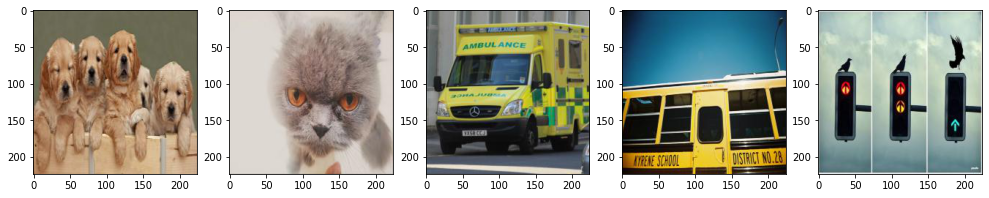

In [ ]:
imgs = []
for i in range(len(adv_images)):
  imgs.append(adv_images[i][0])

_, axs = plt.subplots(1, 5, figsize=(17, 17))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img/255)
plt.show()

# PCA images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


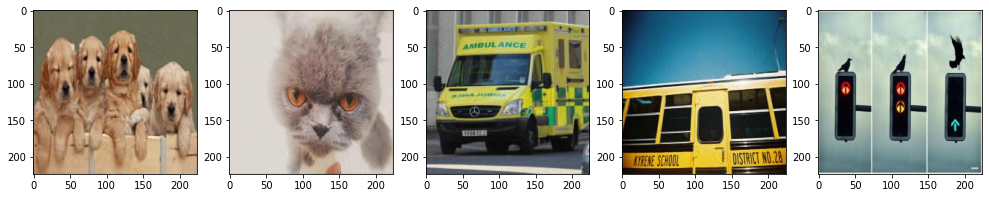

In [ ]:
imgs = []
for i in range(len(adv_images)):
  imgs.append(pca_images[i][0])

_, axs = plt.subplots(1, 5, figsize=(17, 17))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

# Noise images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


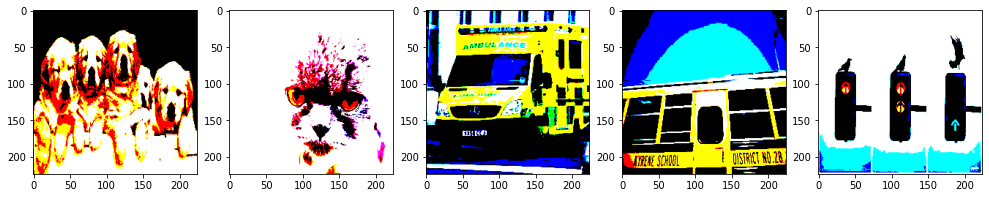

In [ ]:
imgs = []
for i in range(len(adv_images)):
  imgs.append(noise_images[i][0])

_, axs = plt.subplots(1, 5, figsize=(17, 17))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

# Accuracy Graphs

# PCA

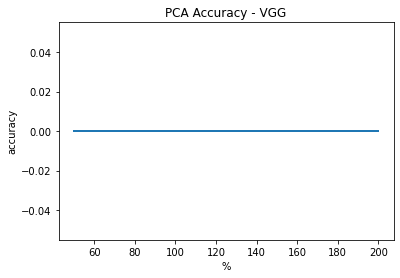

In [ ]:
makegraph(pca_acc_vgg, "PCA Accuracy - VGG")

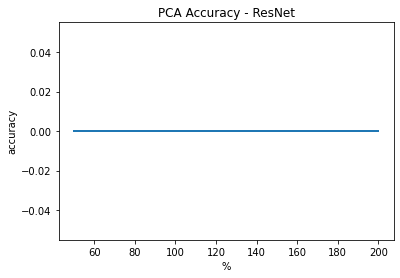

In [ ]:
makegraph(pca_acc_resnet, "PCA Accuracy - ResNet")

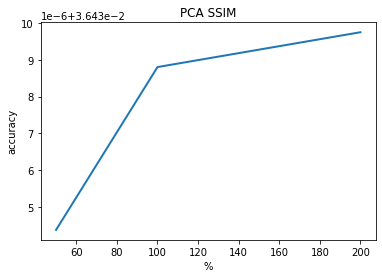

In [ ]:
makegraph(pca_ssim, "PCA SSIM")

# Noise

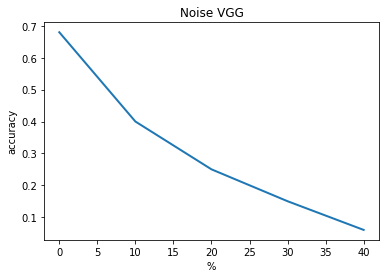

In [ ]:
makegraph(noise_acc_vgg, "Noise VGG")

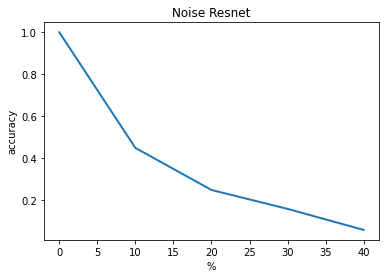

In [ ]:
makegraph(noise_acc_resnet, "Noise Resnet")

# Blur

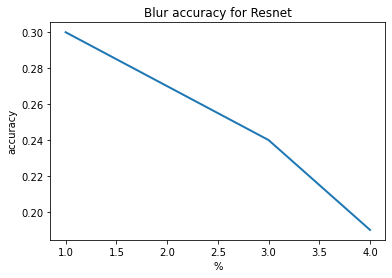

In [ ]:
makegraph(blur_resnet, "Blur accuracy for Resnet")

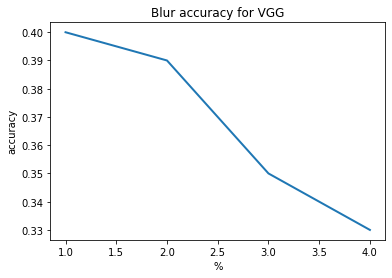

In [ ]:
makegraph(blur_vgg, "Blur accuracy for VGG")

# Results

1. Our idea was, to use PCA to reduce the dimensions of adversarially attacked images and to check if the new generated image still had an effect of the attack. According to our experiments, PCA retains the visual features of the image but completely changes the structure of the images internally which can fool the classifiers easily. 
Thus, if the images are to be used for any ML process, the images should not be compressed using PCA. Methods like JPEG Compression could perform better

2. Our idea was to blur adversarially attacked images to supress the effect of the attacks, however blurring didn't help much as it blurred the image too much.

3. Adversarial attacks produce images that are visually very similar to the original images and in fact have a very high SSIM score as well. In order to improve the model's classification towards adversarial attacks, the models should be trained with adversarial samples to improve its robustness

4. PGD is more powerful than FGSM according to the results. The more accuracy is significantly less on images attacked by PGD and the SSIM score for PGD images is still relatively high

5. In many cases it was observed that ResNet outperforms VGG which was expected.

6. A new dataset containing adversarial images can be generated using the code segments provided. This can help in training and testing new models.

 